<a href="https://colab.research.google.com/github/ThinkingBeyond/BeyondAI-2024/blob/main/Wine_Dataset_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a code that compares Kolmogorov Arnold Networks (KANs) with the Multi-Layer Pereptron (MLPs).

I aim to use graphical representation to understand how each model converges, the maximum accuracy achieved by each model, the loss each model has while training on the dataset.

The comparison would also be done using some criterias such as precision,recall,f1 score and confusion matrix

##Import Necessary Libraries

In [43]:
!pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-cfaywj19
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-cfaywj19
  Resolved https://github.com/KindXiaoming/pykan.git to commit f871c26d4df788ec1ba309c2c9c1803d82606b06
  Preparing metadata (setup.py) ... done


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from kan import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings("ignore")

##Models

The models are being called here along with the number of layers, activation function and other hyperparameters needed for the initial run

In [59]:
#MLP Model
mlp = MLPClassifier(hidden_layer_sizes=(5,5,5),
                    max_iter=1,
                    activation='tanh',
                    learning_rate='adaptive',
                    alpha= 0.1,
                    solver='adam',
                    random_state=42,
                    verbose = False)

#KAN Model
width = [13,5,5,5,3] # should be adjusted based on dataset
kan = KAN(width=width, grid=5, k=3, seed=42)

checkpoint directory created: ./model
saving model version 0.0


#Functions

All the functions to be used for calculating the accuracies, losses, precision, recall, confusion matrix. The function to plot the graph is also written here.

##Model Functions

In [46]:
def MLP_run(mlp,X_train,y_train,X_test,y_test):
  y_train = torch.tensor(y_train, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)
  criterion = nn.MSELoss()
  start_time = time.time()
  mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))
  y_pred_train = mlp.predict(X_train)
  train_acc = accuracy_score(y_train, y_pred_train)
  train_loss = criterion(torch.tensor(y_pred_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))

  y_pred_test = mlp.predict(X_test)
  test_acc = accuracy_score(y_test, y_pred_test)
  test_loss = criterion(torch.tensor(y_pred_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
  end_time = time.time()
  MLP_Execution_Time = end_time - start_time
  return train_acc, test_acc, train_loss, test_loss, MLP_Execution_Time


def KAN_run(model,X_train,y_train,X_test,y_test,epochs):
  y_train = torch.tensor(y_train, dtype=torch.long)
  y_test = torch.tensor(y_test, dtype=torch.long)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
  loss_fn = nn.CrossEntropyLoss()
  kan_train_accuracy = []
  kan_test_accuracy = []
  kan_train_loss = []
  kan_test_loss = []
  starting_time = time.time()
  for epoch in range(epochs): #training
    optimizer.zero_grad()
    outputs = model(X_train)
    predicted = torch.argmax(outputs, dim=1)
    train_accuracy = accuracy_score(y_train-1, predicted)
    train_loss = loss_fn(outputs, y_train-1)
    train_loss.backward()
    optimizer.step()
    kan_train_accuracy.append(train_accuracy)
    kan_train_loss.append(train_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],KAN Train Loss: {train_loss.item():.3f}, KAN Train Accuracy: {train_accuracy}')
  for epoch in range(epochs): # testing
    predicted = model(x_test_tensor)
    test_accuracy = accuracy_score(y_test_tensor, predicted.argmax(1)+1)
    test_loss = loss_fn(predicted, y_test_tensor-1)
    kan_test_accuracy.append(test_accuracy)
    kan_test_loss.append(test_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],KAN Test Loss: {test_loss.item():.3f},KAN Test Accuracy: {test_accuracy:.3f}')
  final_time = time.time()
  KAN_Execution_Time = final_time - starting_time
  return kan_train_accuracy, kan_test_accuracy, kan_train_loss, kan_test_loss, KAN_Execution_Time

##Model Run Function

In [47]:
def run_models(epochs):
  train_accuracies,test_accuracies,train_losses,test_losses = [],[],[],[]
  execution_time = 0
  for i in range(epochs):
    mlp_model_run = MLP_run(mlp,x_train_tensor,y_train_tensor,x_test_tensor,y_test_tensor)
    execution_time += mlp_model_run[4]
    train_accuracies.append(mlp_model_run[0])
    test_accuracies.append(mlp_model_run[1])
    train_losses.append(mlp_model_run[2])
    test_losses.append(mlp_model_run[3])
    if (i + 1) % 10 == 0:
      print(f'Epoch [{i+1}/{epochs}],MLP Train Loss: {mlp_model_run[2]:.3f}, MLP Train Accuracy: {mlp_model_run[0]}')
  print()
  for i in range(epochs):
    if (i +1)% 10 == 0:
      print(f'Epoch [{i+1}/{epochs}],MLP Test Loss: {mlp_model_run[3]:.3f}, MLP Test Accuracy: {mlp_model_run[1]}')
  mlp_metrics = [train_accuracies,test_accuracies,train_losses,test_losses]
  print(f'MLP Execution time: {execution_time:.2f} seconds')
  print()
  kan_model_run = KAN_run(kan,x_train_tensor,y_train_tensor,x_test_tensor,y_test_tensor,epochs)
  kan_metrics = [kan_model_run[0],kan_model_run[1],kan_model_run[2],kan_model_run[3]]
  print(f'KAN Execution time: {kan_model_run[4]:.2f} seconds')

  return mlp_metrics,kan_metrics

##Plot Function

In [48]:
def plot_comparison_over_epochs(mlp_metrics,kan_metrics, num_epochs):
    epochs = range(1, num_epochs + 1)
    mlp_train_acc, mlp_test_acc, mlp_train_loss, mlp_test_loss = mlp_metrics
    kan_train_acc, kan_test_acc, kan_train_loss, kan_test_loss = kan_metrics

    plt.figure(figsize=(10,6))

    # Graph of Train Accuracy for both models over number of epochs
    plt.subplot(221)
    plt.plot(epochs, mlp_train_acc, label='MLP Train Accuracy',color='blue' )
    plt.plot(epochs, mlp_test_acc, label='MLP Test Accuracy',color='red' )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('MLP Train and Test Accuracy Over Epochs')
    plt.legend()

    # Graph of Test Accuracy for both models over number of epochs
    plt.subplot(222)
    plt.plot(epochs, kan_train_acc, label='KAN Train Accuracy',color='blue')
    plt.plot(epochs, kan_test_acc, label='KAN Test Accuracy',color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('KAN Train and Test Accuracy Over Epochs')
    plt.legend()

    # Graph of loss of both models during training
    plt.subplot(223)
    plt.plot(epochs, mlp_train_loss, label='MLP Train Loss')
    plt.plot(epochs, kan_train_loss, label='KAN Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

##Comparison Criteria Functions

In [49]:
def criteria_comparison(mlp,kan,x_test_tensor,y_test_tensor):
  mlp_classification= classification_report(y_test_tensor, mlp.predict(x_test_tensor))
  kan_classification = classification_report(y_test_tensor, kan(x_test_tensor).argmax(1)+1)
  mlp_confusion = confusion_matrix(y_test_tensor, mlp.predict(x_test_tensor))
  kan_confusion = confusion_matrix(y_test_tensor, kan(x_test_tensor).argmax(1)+1)
  print(f'MLP Classification Report:\n{mlp_classification}')
  print(f'MLP Confusion Matrix:\n{mlp_confusion}')
  print(f'KAN Classification Report:\n{kan_classification}')
  print(f'KAN Confusion Matrix:\n{kan_confusion}')

#Dataset

The dataset to be used for the analysis is loaded here as well as preparation for the dataset using standard scaler(to make every feature have a mean of 0 and a standard deviation of 1) for faster convergence and imporved performance

##Load Dataset

In [50]:
url_wine = 'https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv'
df = pd.read_csv(url_wine)
x = df.drop('Wine', axis=1).values
y = df['Wine'].values

##Prepare Dataset

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
# Converting data to tensors
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)

# Runing the model


Running the models over epochs

Plotting the accuracies and loss over epochs

Calculating other comparison criteria



## Runing each model

In [52]:
epochs = 50
mlp_metrics,kan_metrics = run_models(epochs)

Epoch [10/50],MLP Train Loss: 0.953, MLP Train Accuracy: 0.4716981132075472
Epoch [20/50],MLP Train Loss: 0.858, MLP Train Accuracy: 0.4811320754716981
Epoch [30/50],MLP Train Loss: 0.802, MLP Train Accuracy: 0.5094339622641509
Epoch [40/50],MLP Train Loss: 0.792, MLP Train Accuracy: 0.5188679245283019
Epoch [50/50],MLP Train Loss: 0.679, MLP Train Accuracy: 0.5471698113207547

Epoch [10/50],MLP Test Loss: 1.014, MLP Test Accuracy: 0.5694444444444444
Epoch [20/50],MLP Test Loss: 1.014, MLP Test Accuracy: 0.5694444444444444
Epoch [30/50],MLP Test Loss: 1.014, MLP Test Accuracy: 0.5694444444444444
Epoch [40/50],MLP Test Loss: 1.014, MLP Test Accuracy: 0.5694444444444444
Epoch [50/50],MLP Test Loss: 1.014, MLP Test Accuracy: 0.5694444444444444
MLP Execution time: 0.21 seconds

Epoch [10/50],KAN Train Loss: 0.007, KAN Train Accuracy: 1.0
Epoch [20/50],KAN Train Loss: 0.004, KAN Train Accuracy: 1.0
Epoch [30/50],KAN Train Loss: 0.011, KAN Train Accuracy: 0.9905660377358491
Epoch [40/50],KAN

##Plotting Accuracy and Loss function

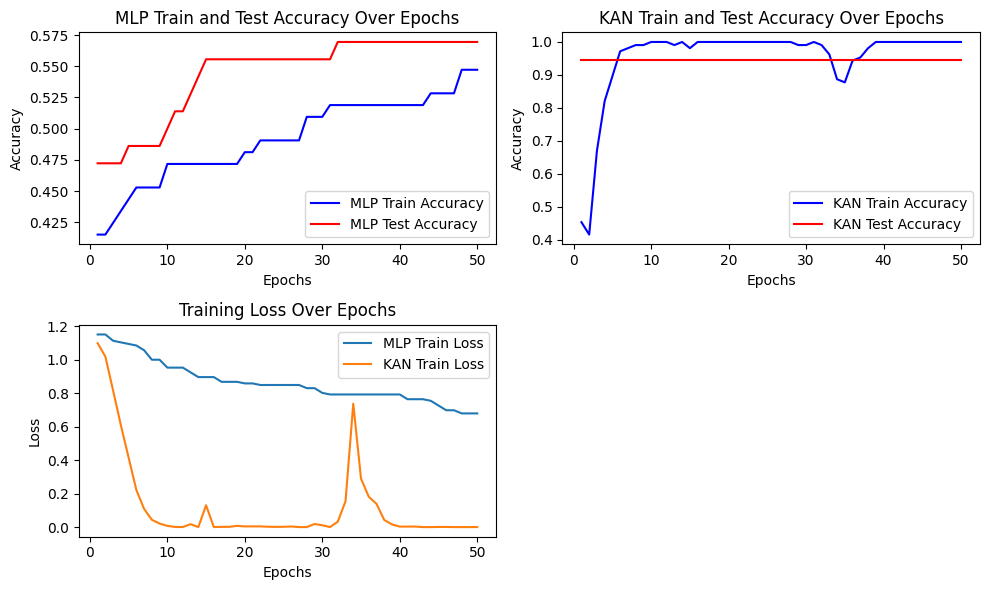

In [53]:
plot_comparison_over_epochs(mlp_metrics, kan_metrics,epochs)

## Calculating the f1 score, precision, recall, and the confusion matrix (how well each model classifies each classes)

In [54]:
criteria_comparison(mlp,kan,x_test_tensor,y_test_tensor)

MLP Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        26
           2       0.65      0.81      0.72        27
           3       0.50      1.00      0.67        19

    accuracy                           0.57        72
   macro avg       0.38      0.60      0.46        72
weighted avg       0.37      0.57      0.45        72

MLP Confusion Matrix:
[[ 0 12 14]
 [ 0 22  5]
 [ 0  0 19]]
KAN Classification Report:
              precision    recall  f1-score   support

           1       0.87      1.00      0.93        26
           2       1.00      0.85      0.92        27
           3       1.00      1.00      1.00        19

    accuracy                           0.94        72
   macro avg       0.96      0.95      0.95        72
weighted avg       0.95      0.94      0.94        72

KAN Confusion Matrix:
[[26  0  0]
 [ 4 23  0]
 [ 0  0 19]]


#Hyperparameter Tunning

## Mlp

In [55]:
param_grid_mlp = {
    'hidden_layer_sizes': [(5,5,5), (10,10), (15,15)],
    'activation': ['relu', 'tanh'],
    'alpha':[0.001,0.01,0.1],
    'learning_rate':['adaptive','constant'],
    'solver':['adam','sgd']}
mlp = MLPClassifier(max_iter=1000, random_state=42)
clf = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring='accuracy')
clf.fit(x_train_tensor, y_train_tensor)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000, random_state=42),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(5, 5, 5), (10, 10), (15, 15)],
                         'learning_rate': ['adaptive', 'constant'],
                         'solver': ['adam', 'sgd']},
             scoring='accuracy')

In [56]:
print(f"Best accuracy: {clf.best_score_}")
print(f"Best parameters: {clf.best_params_}")

Best accuracy: 0.9714285714285713
Best parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (15, 15), 'learning_rate': 'adaptive', 'solver': 'adam'}


# Final Run

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/50],MLP Train Loss: 0.538, MLP Train Accuracy: 0.660377358490566
Epoch [20/50],MLP Train Loss: 0.434, MLP Train Accuracy: 0.7075471698113207
Epoch [30/50],MLP Train Loss: 0.377, MLP Train Accuracy: 0.7641509433962265
Epoch [40/50],MLP Train Loss: 0.274, MLP Train Accuracy: 0.839622641509434
Epoch [50/50],MLP Train Loss: 0.226, MLP Train Accuracy: 0.8584905660377359

Epoch [10/50],MLP Test Loss: 0.347, MLP Test Accuracy: 0.8194444444444444
Epoch [20/50],MLP Test Loss: 0.347, MLP Test Accuracy: 0.8194444444444444
Epoch [30/50],MLP Test Loss: 0.347, MLP Test Accuracy: 0.8194444444444444
Epoch [40/50],MLP Test Loss: 0.347, MLP Test Accuracy: 0.8194444444444444
Epoch [50/50],MLP Test Loss: 0.347, MLP Test Accuracy: 0.8194444444444444
MLP Execution time: 0.29 seconds

Epoch [10/50],KAN Train Loss: 0.000, KAN Train Accuracy: 1.0
Epoch [20/50],KAN Train Loss: 0.000, KAN Train Accuracy: 1.0
Epoch [30/50],KAN Train Loss: 0.

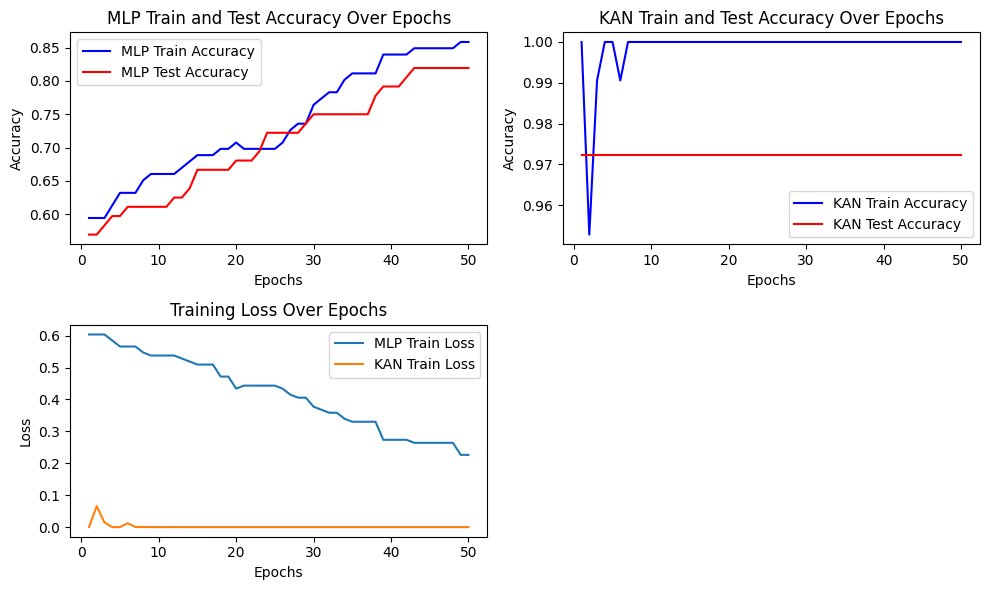

MLP Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        26
           2       0.33      0.81      0.47        27
           3       0.00      0.00      0.00        19

    accuracy                           0.31        72
   macro avg       0.11      0.27      0.16        72
weighted avg       0.12      0.31      0.18        72

MLP Confusion Matrix:
[[ 0 26  0]
 [ 2 22  3]
 [ 1 18  0]]
KAN Classification Report:
              precision    recall  f1-score   support

           1       0.53      0.77      0.62        26
           2       0.74      0.93      0.82        27
           3       0.00      0.00      0.00        19

    accuracy                           0.62        72
   macro avg       0.42      0.57      0.48        72
weighted avg       0.47      0.62      0.53        72

KAN Confusion Matrix:
[[20  6  0]
 [ 2 25  0]
 [16  3  0]]


In [63]:
mlp_new = MLPClassifier(hidden_layer_sizes=(15,15),
                    max_iter=1,
                    activation='tanh',
                    learning_rate='adaptive',
                    alpha= 0.001,
                    solver='adam',
                    random_state=42,
                    verbose = False)

width = [13,15,3]
kan_new= KAN(width=width, grid=2, k=5, seed=42)
epochs = 50
mlp_metrics_new,kan_metrics_new = run_models(epochs)
plot_comparison_over_epochs(mlp_metrics_new, kan_metrics_new,epochs)
mlp_new.fit(x_train_tensor, y_train_tensor)
criteria_comparison(mlp_new,kan_new,x_test_tensor,y_test_tensor)